In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingRegressor
import optuna
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn import set_config


from IPython.display import clear_output
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/iris-dataset/iris.names
/kaggle/input/iris-dataset/iris_data.csv
/kaggle/input/iris-dataset/bezdekIris.data
/kaggle/input/iris-dataset/Index
/kaggle/input/iris-dataset/iris.data


In [2]:
!pip install autoviz
!pip install xlrd

from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()

clear_output()

Shape of your Data Set loaded: (149, 5)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  4
    Number of Integer-Categorical Columns =  0
    Number of String-Categorical Columns =  1
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  0
    Number of Columns to Delete =  0
    5 Predictors classified...
        This does not include the Target column(s)
        No variables removed since no ID or low-information variables found in data set
Number of All Scatter Plots = 10


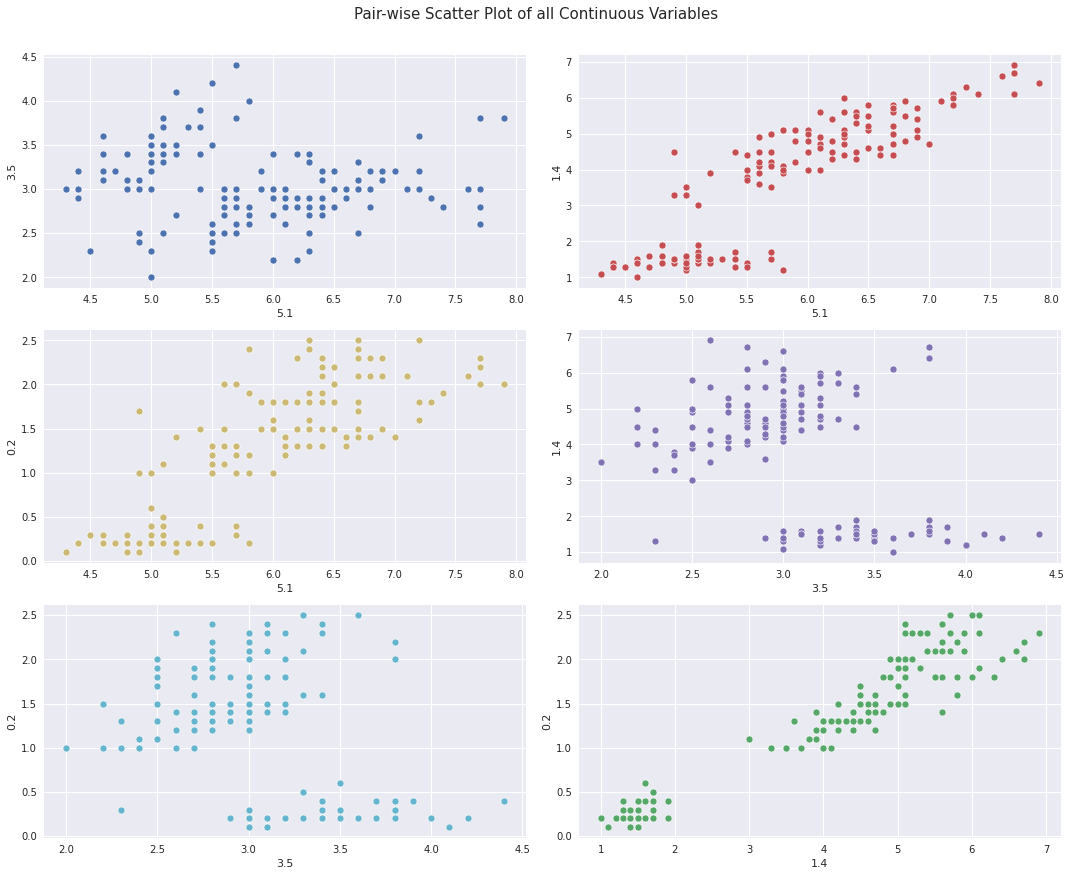

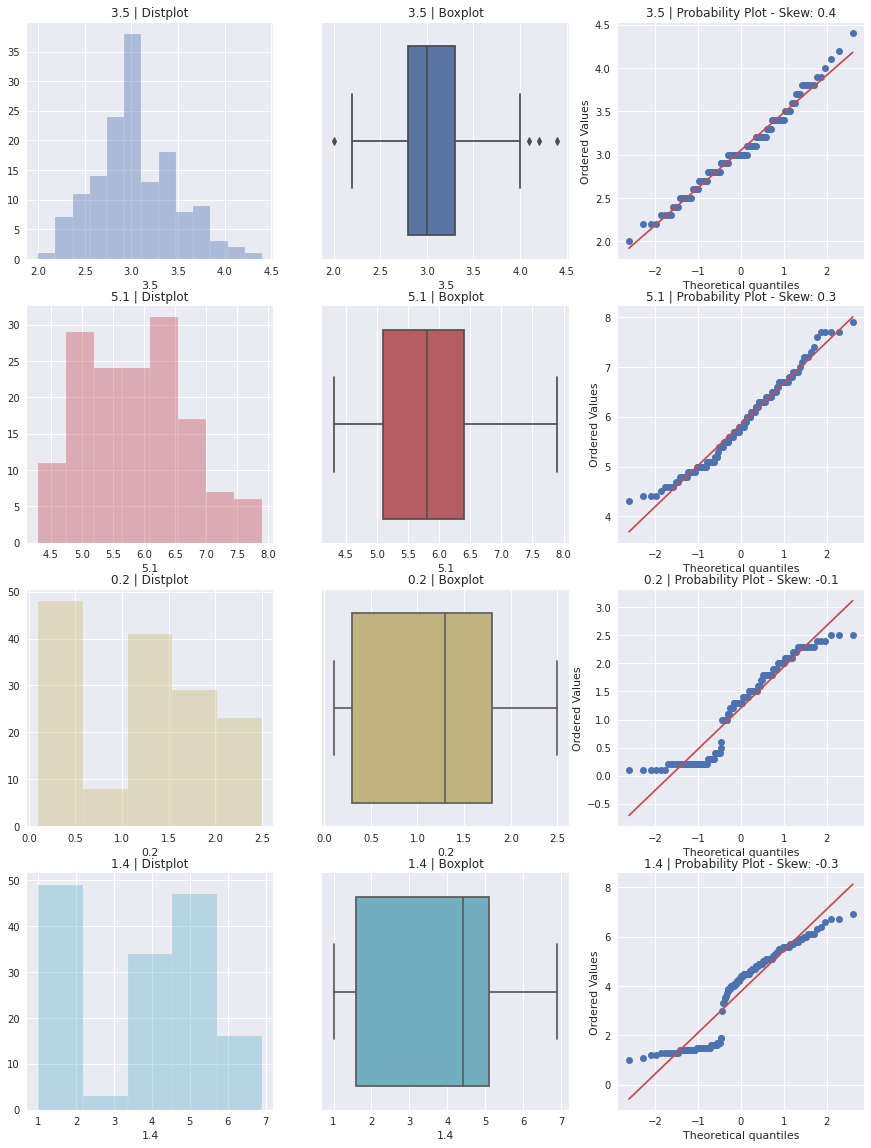

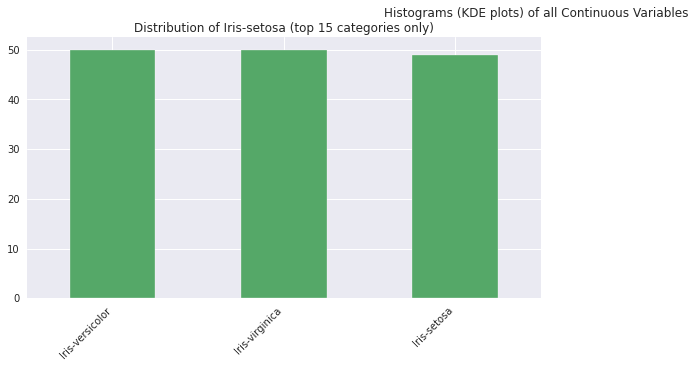

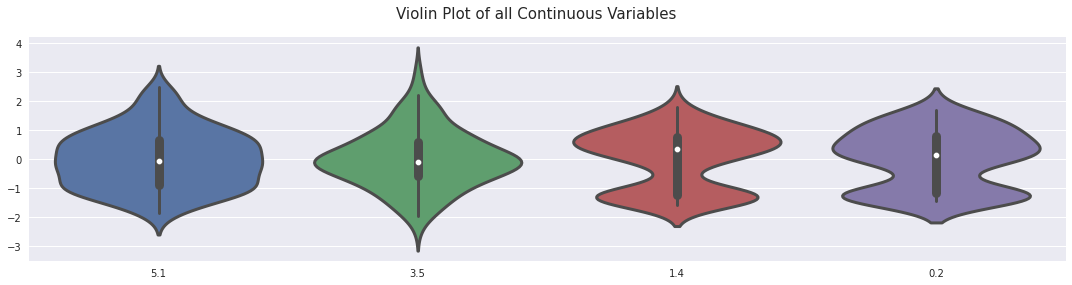

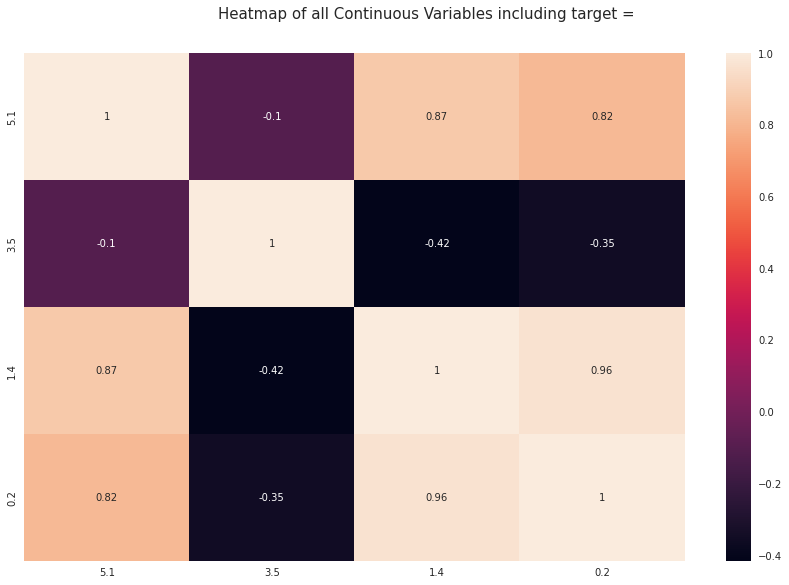

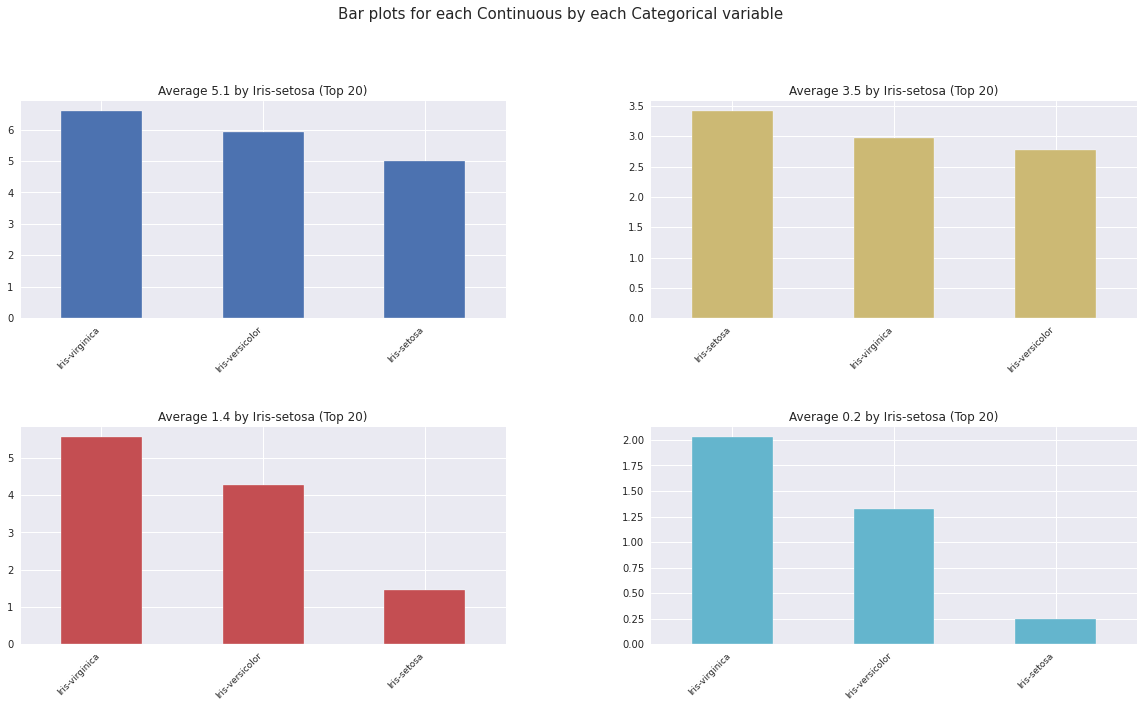

Time to run AutoViz (in seconds) = 5.789

 ###################### VISUALIZATION Completed ########################


In [3]:
fig = AV.AutoViz('../input/iris-dataset/iris_data.csv')

In [4]:
train = pd.read_csv("../input/iris-dataset/iris_data.csv")
#Preview data
train

,5.1,3.5,1.4,0.2,Iris-setosa
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa
...,...,...,...,...,...
144,6.7,3.0,5.2,2.3,Iris-virginica
145,6.3,2.5,5.0,1.9,Iris-virginica
146,6.5,3.0,5.2,2.0,Iris-virginica
147,6.2,3.4,5.4,2.3,Iris-virginica


In [5]:
train.columns =["sepal_length", "sepal_width", "petal_length", "petal_width" , "species"]
new_row = pd.DataFrame({'sepal_length':5.1, 'sepal_width':3.5, 'petal_length':1.4,
                        'petal_width':0.2, 'species':"Iris-setosa"},index =[0])
train = pd.concat([new_row, train]).reset_index(drop = True)
train

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


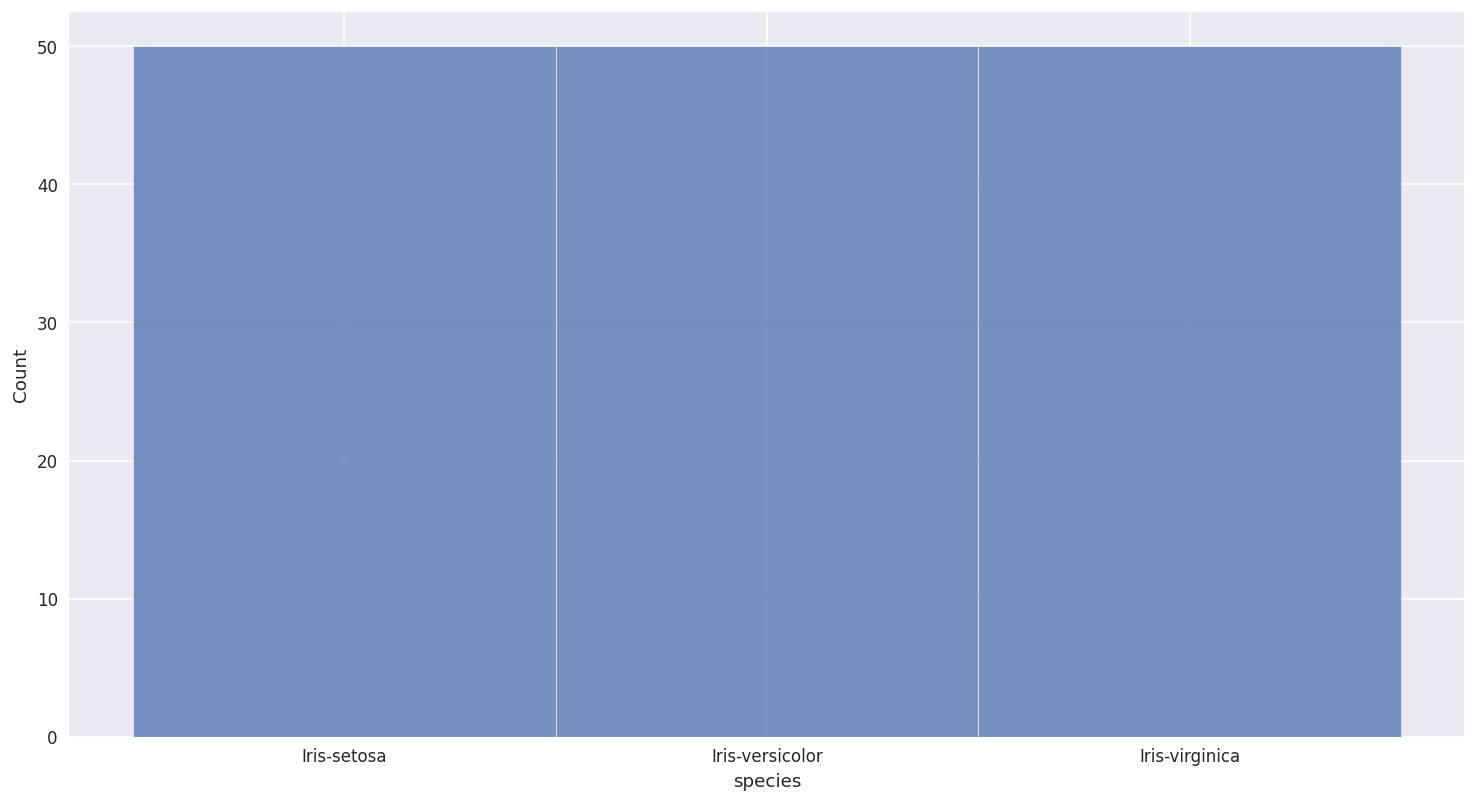

In [6]:
plt.figure(figsize=(15,8), dpi = 120)
sns.histplot(data = train, x = 'species')
plt.show()

In [7]:
# Separate target from features
y_trail = train['species']
features = train.drop(['species'], axis=1)
#Preview features
features.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [8]:
df1 = {"species": 0}
df2 = {"species": 1}
df3 = {"species": 2}
y = pd.DataFrame()
for i in y_trail:
    if i == "Iris-setosa":
        y = y.append(df1, ignore_index = True)
    elif i == "Iris-versicolor":
        y = y.append(df2, ignore_index = True)
    else:
        y = y.append(df3, ignore_index = True)
X = features

In [9]:
pd.DataFrame(train.skew()).style.background_gradient()

,0
sepal_length,0.314911
sepal_width,0.334053
petal_length,-0.274464
petal_width,-0.104997


In [10]:
pd.DataFrame(train).describe()[1:].style.background_gradient(cmap ='YlOrRd', axis = None)

,sepal_length,sepal_width,petal_length,petal_width
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [11]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, X_test.shape

((120, 4), (30, 4))

In [12]:
def objective_lgbm(trial):
    params = {
        'boosting_type': trial.suggest_categorical('boosting_type',['dart', 'gbdt']),
        'num_leaves': trial.suggest_int('num_leaves', 2,256),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e2),
        'n_estimators': trial.suggest_int('n_estimators', 200, 2400, 200),
        'subsample': trial.suggest_float('subsample',0.05,1),
        'min_child_samples' : trial.suggest_int('min_child_samples', 20, 100, 5),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'colsample_bytree' : trial.suggest_loguniform('colsample_bytree', 1e-8, 1.0)
}
    lgbm = LGBMRegressor().set_params(**params)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared= False)
    return rmse

In [13]:
study_lgbm = optuna.create_study(direction = 'minimize')
study_lgbm.optimize(objective_lgbm, n_trials = 1000)

[I 2021-09-11 07:59:34,331] A new study created in memory with name: no-name-3194d3e9-9275-4afb-9872-544807bb0bb5
[I 2021-09-11 07:59:34,457] Trial 0 finished with value: 0.4316288312339075 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'max_depth': 15, 'learning_rate': 0.6552831046986913, 'n_estimators': 1000, 'subsample': 0.17403516671601288, 'min_child_samples': 55, 'reg_lambda': 1.6819926513823698e-06, 'reg_alpha': 4.202726046363615e-05, 'colsample_bytree': 0.0041938517387578}. Best is trial 0 with value: 0.4316288312339075.
[I 2021-09-11 07:59:34,494] Trial 1 finished with value: 0.7762087348130011 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 7, 'learning_rate': 23.231410928264403, 'n_estimators': 1400, 'subsample': 0.7942264196628807, 'min_child_samples': 90, 'reg_lambda': 0.1894145456663784, 'reg_alpha': 7.70965480634493e-05, 'colsample_bytree': 0.9027308853203104}. Best is trial 0 with value: 0.4316288312339075.
[I 2021-09-11 07:59:34,53

In [14]:
params_1 = study_lgbm.best_trial.params
params_1

{'boosting_type': 'gbdt',
 'num_leaves': 30,
 'max_depth': 18,
 'learning_rate': 0.6630580901490333,
 'n_estimators': 200,
 'subsample': 0.18563997797610562,
 'min_child_samples': 35,
 'reg_lambda': 0.4554937805136605,
 'reg_alpha': 1.1977179516591714e-05,
 'colsample_bytree': 0.1071502434773458}

In [15]:
def objective_xgb(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
}

    if params['booster'] == 'gbtree' or params['booster'] == 'dart':
        params['max_depth'] = trial.suggest_int('max_depth', 0, 15)
        params['eta'] = trial.suggest_loguniform('eta', 1e-8, 1.0)
        params['gamma'] = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        params['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
        params['subsample'] = trial.suggest_float('subsample', 1e-8,1)
        params['max_bin'] = trial.suggest_int('max_bin',256, 2048, step = 32)
        params['max_leaves'] = trial.suggest_int('max_leaves', 0,20)
    if params['booster'] == 'dart':
        params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        params['rate_drop'] = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
        params['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
    
    xgbreg = XGBRegressor().set_params(**params)
    xgbreg.fit(X_train, y_train)
    y_pred = xgbreg.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared= False)
    return rmse

In [16]:
study_xgb = optuna.create_study(direction = 'minimize')
study_xgb.optimize(objective_xgb, n_trials = 1000)

[I 2021-09-11 08:05:02,446] A new study created in memory with name: no-name-6379fc7e-9235-451f-b923-e8754386087d
[I 2021-09-11 08:05:02,613] Trial 0 finished with value: 0.1240901264619872 and parameters: {'booster': 'dart', 'reg_lambda': 0.002270665528733853, 'reg_alpha': 1.2187929715300516e-08, 'max_depth': 12, 'eta': 0.050059242979964634, 'gamma': 5.803309379804163e-05, 'grow_policy': 'depthwise', 'subsample': 0.1281819566628687, 'max_bin': 1280, 'max_leaves': 15, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0012345652792014365, 'skip_drop': 8.009146429710492e-05}. Best is trial 0 with value: 0.1240901264619872.
[I 2021-09-11 08:05:02,679] Trial 1 finished with value: 0.3020578431565104 and parameters: {'booster': 'gbtree', 'reg_lambda': 2.9772518434970913e-05, 'reg_alpha': 1.3784095231905836e-05, 'max_depth': 10, 'eta': 0.01346613093877582, 'gamma': 0.019222292419935574, 'grow_policy': 'depthwise', 'subsample': 0.631697468906587, 'max_bin': 608, 'max_leaves':

In [17]:
params_2 = study_xgb.best_trial.params
params_2

{'booster': 'dart',
 'reg_lambda': 1.3449286739240554e-08,
 'reg_alpha': 0.006106806283408004,
 'max_depth': 10,
 'eta': 0.997375336053658,
 'gamma': 2.1390936791114603e-07,
 'grow_policy': 'lossguide',
 'subsample': 0.3504909121656502,
 'max_bin': 256,
 'max_leaves': 12,
 'sample_type': 'uniform',
 'normalize_type': 'forest',
 'rate_drop': 0.986851764509523,
 'skip_drop': 1.1038767819939958e-06}

In [18]:
lgbm = LGBMRegressor(** params_1)

xgb = XGBRegressor(** params_2)

stacking_model = StackingRegressor([
    ('lgbm', lgbm),
    ('xgb', xgb)
])

In [19]:
set_config(display='diagram')
stacking_model

StackingRegressor(estimators=[('lgbm',
                               LGBMRegressor(colsample_bytree=0.1071502434773458,
                                             learning_rate=0.6630580901490333,
                                             max_depth=18, min_child_samples=35,
                                             n_estimators=200, num_leaves=30,
                                             reg_alpha=1.1977179516591714e-05,
                                             reg_lambda=0.4554937805136605,
                                             subsample=0.18563997797610562)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster='dart',
                                            colsample_bylevel=...
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=12,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            normalize_type='forest',
                                            num_parallel_tree=None,
                                            random_state=None,
                                            rate_drop=0.986851764509523,
                                            reg_alpha=0.006106806283408004,
                                            reg_lambda=1.3449286739240554e-08,
                                            sample_type='uniform',
                                            scale_pos_weight=None,
                                            skip_drop=1.1038767819939958e-06, ...))])

In [20]:
stacking_model.fit(X, y)

StackingRegressor(estimators=[('lgbm',
                               LGBMRegressor(colsample_bytree=0.1071502434773458,
                                             learning_rate=0.6630580901490333,
                                             max_depth=18, min_child_samples=35,
                                             n_estimators=200, num_leaves=30,
                                             reg_alpha=1.1977179516591714e-05,
                                             reg_lambda=0.4554937805136605,
                                             subsample=0.18563997797610562)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster='dart',
                                            colsample_bylevel=...
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=12,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            normalize_type='forest',
                                            num_parallel_tree=None,
                                            random_state=None,
                                            rate_drop=0.986851764509523,
                                            reg_alpha=0.006106806283408004,
                                            reg_lambda=1.3449286739240554e-08,
                                            sample_type='uniform',
                                            scale_pos_weight=None,
                                            skip_drop=1.1038767819939958e-06, ...))])

In [21]:
final_y_pred = stacking_model.predict(X_test)
mse = mean_squared_error(y_test, final_y_pred, squared= False)
mae = mean_absolute_error(final_y_pred,y_test)

In [22]:
print("Mean Absolute Error:" , mae)
print("Mean Sqared Error:" , mse)

Mean Absolute Error: 0.013887457197545323
Mean Sqared Error: 0.04671729507245375
